### COS80026 - DATA SCIENCE PROJECT 2

### Assignment 3

### Electricity Usage Analytics

### Group 4

In [1]:
# Importing necessary module
import pandas as pd
import numpy as np
import matplotlib as mpl
from datetime import datetime
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import math
from geopy.distance import geodesic
import haversine as hs
import glob
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
os.remove("main_dataset.csv")
print("File Removed!")

File Removed!


In [3]:
#Loading datasets as one main dataframe
files=glob.glob('*.csv')
df_list = []
for file in files:
    df_list.append(pd.read_csv(file, sep=','))
main_df = pd.concat(df_list, ignore_index=True)
main_df.to_csv("main_dataset.csv",  index=False)
#Renaming columns
main_df = main_df.rename(columns={'READ DATE':'date','CONSUMPTION(KWH)':'consumption', 
                                  'SOLD TO GRID(KWH)':'sold'})
#Display a random sampling of 5 rows
main_df.sample(5, random_state=0)

,date,consumption,sold
66,07 December 2020,2.71,11.22
156,05 February 2021,3.15,10.44
247,06 May 2020,Not available,Not available
267,26 May 2020,0.30,0.57
145,24 June 2020,3.94,0.15


In [4]:
#Checking datatypes of attributes
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         304 non-null    object
 1   consumption  304 non-null    object
 2   sold         304 non-null    object
dtypes: object(3)
memory usage: 7.2+ KB


In [5]:
#Converting the 'date' column to datetime format
main_df['date']= pd.to_datetime(main_df['date'])
#Sorting data by date
main_df = main_df.sort_values(by='date')
#Removing non-numeric data 
main_df = main_df[main_df['consumption'] != 'Not available']
#Converting datatype of 'consumption' and 'sold' to float
main_df['consumption'] = pd.to_numeric(main_df['consumption'], downcast='float')
main_df['sold'] = pd.to_numeric(main_df['sold'], downcast='float')
#Checking datatypes of attributes
main_df.info()
#Display a random sampling of 5 rows
main_df.sample(5, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 248 to 174
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         293 non-null    datetime64[ns]
 1   consumption  293 non-null    float32       
 2   sold         293 non-null    float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 6.9 KB


,date,consumption,sold
78,2020-12-19,1.56,12.69
167,2021-02-16,2.90,12.64
61,2020-12-02,2.56,15.90
115,2020-10-25,15.95,0.88
31,2020-09-02,13.90,0.73


In [6]:
#Setting date to index
main_df = main_df.set_index('date')
#Adding columns for weekdays, month and year
main_df['weekday'] = main_df.index.day_name()
main_df['year'] = main_df.index.year
main_df['month'] = main_df.index.month
main_df['month'] = main_df['month'].apply(lambda x: calendar.month_abbr[x])
#Display a random sampling of 5 rows
main_df.sample(5, random_state=0)

,consumption,sold,weekday,year,month
date,,,,,
2020-12-19,1.56,12.69,Saturday,2020,Dec
2021-02-16,2.90,12.64,Tuesday,2021,Feb
2020-12-02,2.56,15.90,Wednesday,2020,Dec
2020-10-25,15.95,0.88,Sunday,2020,Oct
2020-09-02,13.90,0.73,Wednesday,2020,Sep


In [7]:
main_df.head()

,consumption,sold,weekday,year,month
date,,,,,
2020-05-07,0.29,0.0,Thursday,2020,May
2020-05-08,0.34,0.0,Friday,2020,May
2020-05-09,0.41,0.0,Saturday,2020,May
2020-05-10,0.52,0.0,Sunday,2020,May
2020-05-11,0.35,0.0,Monday,2020,May


In [8]:
main_df.tail()

,consumption,sold,weekday,year,month
date,,,,,
2021-02-19,3.66,11.73,Friday,2021,Feb
2021-02-20,3.04,9.94,Saturday,2021,Feb
2021-02-21,2.54,3.54,Sunday,2021,Feb
2021-02-22,3.43,6.92,Monday,2021,Feb
2021-02-23,6.53,13.02,Tuesday,2021,Feb


In [9]:
#Checking if consumption ever goes to 0 
main_df[main_df['consumption'] == 0.0]

,consumption,sold,weekday,year,month
date,,,,,


In [10]:
#Checking if sold ever goes to 0
print(main_df[main_df['sold'] == 0.0].groupby(['month'], as_index=False)['sold'].count())

  month  sold
0   May     7
1   Oct     8
2   Sep     1


<AxesSubplot:xlabel='date'>

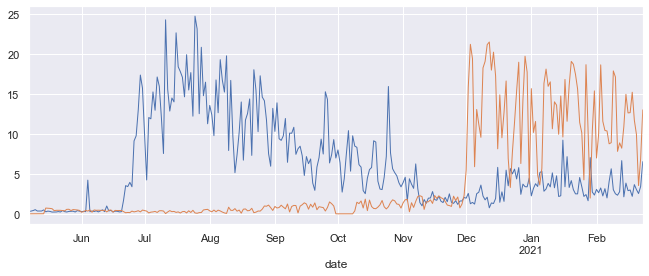

In [11]:
#Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
#Plotting 'consumption' by month
main_df['consumption'].plot(linewidth=1)
#Plotting 'sold' by month
main_df['sold'].plot(linewidth=1)

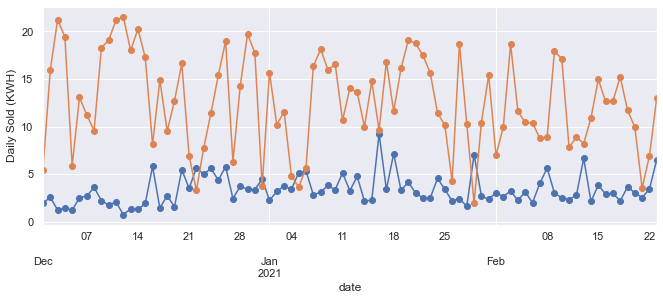

In [12]:
#Focusing on daily data from December to February
ax = main_df.loc['2020-12':'2021-02', 'consumption'].plot(marker='o', linestyle='-')
ax = main_df.loc['2020-12':'2021-02', 'sold'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Sold (KWH)');

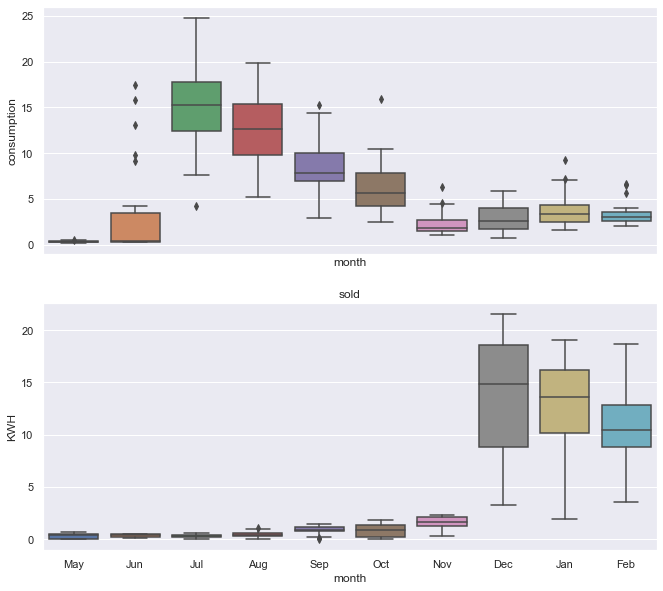

In [13]:
#Plotting boxplots of 'consumption' and 'sold' by month
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['consumption', 'sold'], axes):
    sns.boxplot(data=main_df, x='month', y=name, ax=ax)
ax.set_ylabel('KWH')
ax.set_title(name)
# Removing the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

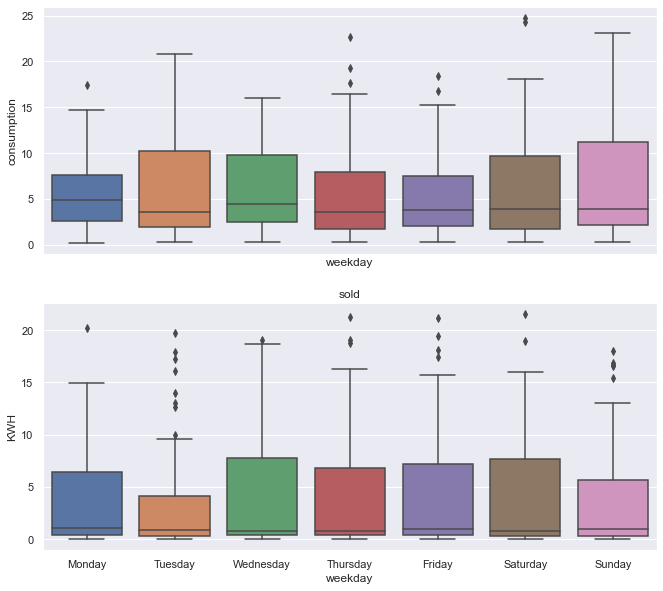

In [14]:
#Plotting boxplots of 'consumption' and 'sold' by month
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
my_order = order = ['Monday','Tuesday','Wednesday','Thursday',
                    'Friday','Saturday','Sunday']
for name, ax in zip(['consumption', 'sold'], axes):
    sns.boxplot(data=main_df, x='weekday', y=name, ax=ax, order = my_order)
ax.set_ylabel('KWH')
ax.set_title(name)
#Removing the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

Find amount of sunlight data

Find season data

Stack the data with our data

Prove:

1. Summer, more sunlight, less consumption, more sold

2. Winter, less sunlight, more consumption, less sold

3. Not much difference between weekdays and weekends

4. Why is initial consumption in May/June so low --  almost 0? Study.